In [1]:
import os
import sys
sys.path.insert(0, '../')
from qgan_superres_results_runner import RCPS_Results_Runner

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_style("white")

from PIL import Image
import torch

import pandas as pd
import all_utils

%load_ext autoreload
%autoreload 2




/data/scratch/swamiviv/.envs/gen_duq/lib/python3.7/site-packages/torch/cuda/__init__.py:104: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [2]:
base_dir = 'assets'
exp_name = 'super_resolution'
model_name = 'models/superres_alpha_0.1.pt'

resize_factors = [1, 16, 32]
difficulty_levels = ['easy', 'medium', 'hard']
results_obj = RCPS_Results_Runner(base_dir=base_dir, exp_name=exp_name, model_name=model_name, resize_factors=resize_factors, difficulty_levels=difficulty_levels, norm_scheme='mean')

Loaded quantile encoder model from /data/scratch/swamiviv/projects/generative_uncertainty/assets/super_resolution/models/superres_alpha_0.1.pt
Performing down-sampling with factors: [32]
BilinearResize Initialized with factors: [32] and probs: None
BilinearResize Initialized with factors: [32] and probs: None
Channel number: 8, in_channel: 512, out_channel: 512
Channel number: 16, in_channel: 512, out_channel: 512
Channel number: 32, in_channel: 512, out_channel: 512
Channel number: 64, in_channel: 512, out_channel: 512
Channel number: 128, in_channel: 512, out_channel: 256
Channel number: 256, in_channel: 256, out_channel: 128
Channel number: 512, in_channel: 128, out_channel: 64
Channel number: 1024, in_channel: 64, out_channel: 32
Loading pSp from checkpoint: /data/scratch/swamiviv/projects/generative_uncertainty/assets/super_resolution/pretrained_models/psp_celebs_super_resolution.pt
Loaded pretrained psp generator model from /data/scratch/swamiviv/projects/generative_uncertainty/a

In [3]:
results_obj.compute_losses_prediction_sets()

In [4]:
results_obj.calibrate_all_difficulty_levels(total_runs=100)

Run 0 | Lambda: 1.2727  |  AER: 0.0824  |  RhatPlus: 0.0903 | Uncalibrated risk: 0.1615 | Calibrated risk: 0.0824
Run 1 | Lambda: 1.2727  |  AER: 0.0889  |  RhatPlus: 0.0891 | Uncalibrated risk: 0.1688 | Calibrated risk: 0.0889
Run 2 | Lambda: 1.2727  |  AER: 0.0891  |  RhatPlus: 0.0886 | Uncalibrated risk: 0.1702 | Calibrated risk: 0.0891
Run 3 | Lambda: 1.2727  |  AER: 0.0899  |  RhatPlus: 0.0879 | Uncalibrated risk: 0.1699 | Calibrated risk: 0.0899
Run 4 | Lambda: 1.2727  |  AER: 0.0817  |  RhatPlus: 0.0904 | Uncalibrated risk: 0.1591 | Calibrated risk: 0.0817
Run 5 | Lambda: 1.2727  |  AER: 0.0792  |  RhatPlus: 0.0913 | Uncalibrated risk: 0.1573 | Calibrated risk: 0.0792
Run 6 | Lambda: 1.2727  |  AER: 0.0842  |  RhatPlus: 0.0899 | Uncalibrated risk: 0.1596 | Calibrated risk: 0.0842
Run 7 | Lambda: 1.2727  |  AER: 0.0868  |  RhatPlus: 0.0895 | Uncalibrated risk: 0.1659 | Calibrated risk: 0.0868
Run 8 | Lambda: 1.2727  |  AER: 0.0850  |  RhatPlus: 0.0891 | Uncalibrated risk: 0.1634 

## Set sizes across resolutions

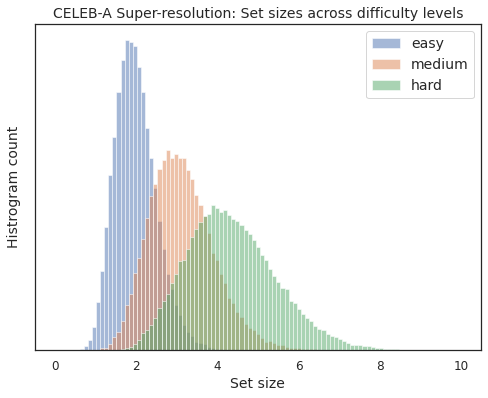

In [5]:
set_sizes_plot = results_obj.plot_set_sizes()
plt.gcf().set_size_inches(8, 6)

## Residuals across resolutions

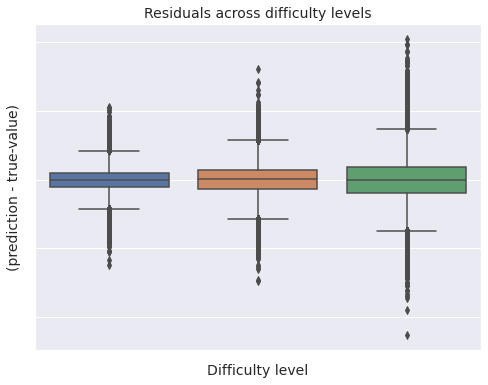

In [16]:
residuals_plot = results_obj.plot_residuals()
plt.gcf().set_size_inches(8, 6)

## Empirical risk before/after calibration

100 100


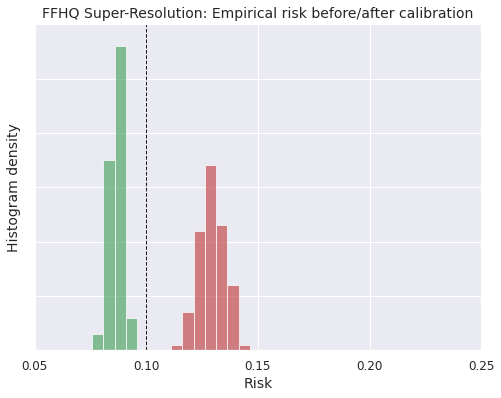

In [17]:
test_idx_list = results_obj.test_idx_list[results_obj.difficulty_levels[0]]
calibrated_risks = results_obj.all_rcps_stats[results_obj.difficulty_levels[0]]['mean_emp_risks']
uncalibrated_risks = []

plt.figure(figsize=(10, 8))
for test_idx_per_run in test_idx_list:
    # Find test indices that overlap with all difficulty
    overlap_indices = []
    for idx, masking_grade in enumerate(results_obj.difficulty_levels):
        all_indices_this_difficulty = results_obj.indices_per_difficulty_level[masking_grade]
        overlap_indices.extend(list(set(all_indices_this_difficulty).intersection(set(test_idx_per_run))))
    uncalibrated_risks.append(results_obj.all_losses_per_lambda[masking_grade][0][np.where(results_obj.lambda_values == 1)[0][0]][overlap_indices, :].mean())
        
        
print(len(uncalibrated_risks), len(calibrated_risks))
        
bins = np.linspace(0.0, 0.5, 100)

plt.hist(uncalibrated_risks, color='r',  bins=bins, label='Before', alpha=0.7)
n, bins, patches = plt.hist(calibrated_risks, color='g', bins=bins, label='After', alpha=0.7)

plt.axvline(x=0.1, linewidth=1, color='k', linestyle='--')
plt.xlim([0.05, 0.2])
plt.ylim([0, 60])
plt.gca().axes.yaxis.set_ticklabels([])
plt.gcf().set_size_inches(8, 6)
all_utils.decorate_plot(
    plt.gca(), xlabel='Risk', ylabel='Histogram density', title_str='FFHQ Super-Resolution: Empirical risk before/after calibration', xticks=np.asarray([0.05, 0.10, 0.15, 0.20, 0.25]))

## Downsampling by 1x

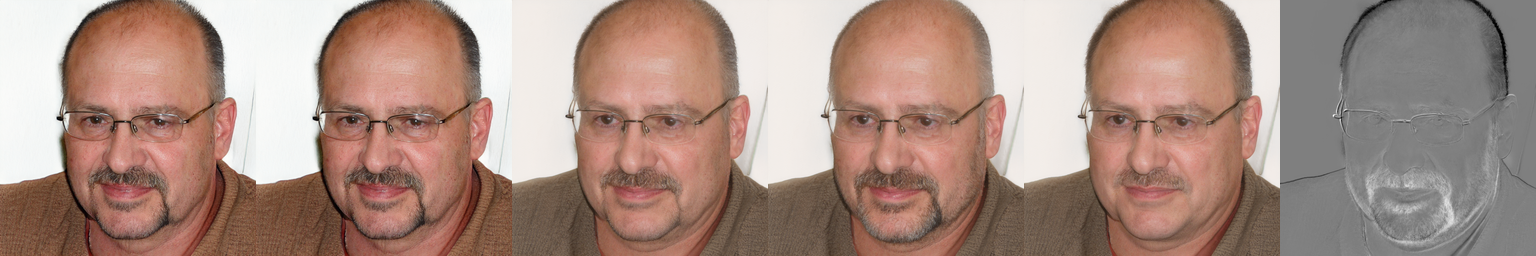

<Figure size 1440x1440 with 0 Axes>

In [22]:
# run_index=-2,  image_num=308 / argsorts[22], model: real_generated_mixed_with_image_mse_alpha_{0.1}_resume , 800000
image_num = 10
run_index = -1
img_desc = f'sample_image'

image_index= results_obj.test_idx_list['easy'][run_index][image_num]
plotted_fig, _ = results_obj.show_outputs_across_difficulty_levels(difficulty_level='easy', image_index=image_index, run_index=run_index)
display(Image.fromarray(plotted_fig))

## Downsampling by 32x

BilinearResize Initialized with factors: [16] and probs: None


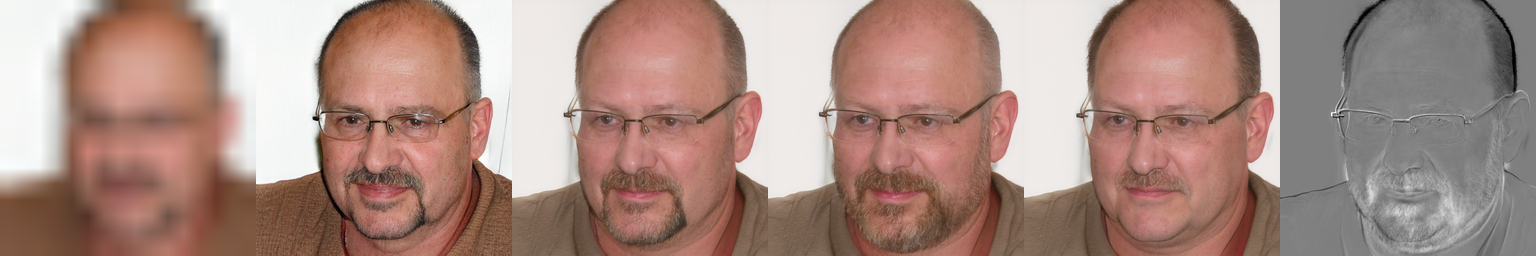

<Figure size 1440x1440 with 0 Axes>

In [23]:
plotted_fig, _ = results_obj.show_outputs_across_difficulty_levels(difficulty_level='medium', image_index=image_index,run_index=run_index)
display(Image.fromarray(plotted_fig))

BilinearResize Initialized with factors: [32] and probs: None


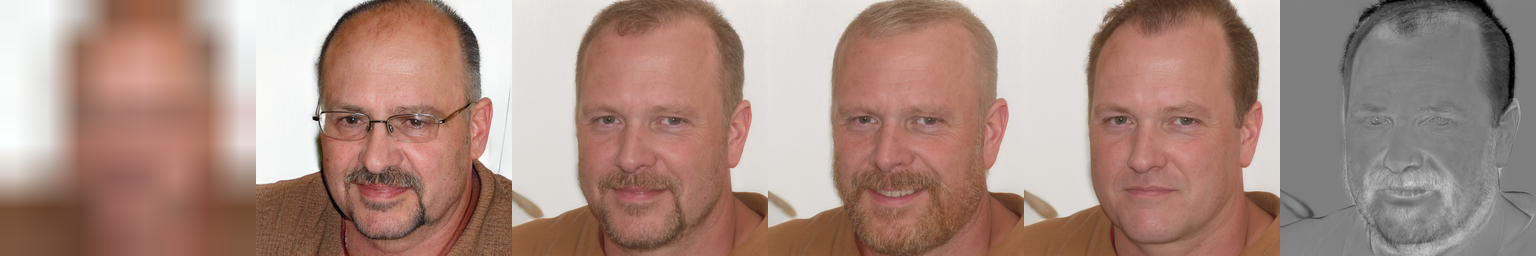

<Figure size 1440x1440 with 0 Axes>

In [24]:
plotted_fig, factor_array_hard = results_obj.show_outputs_across_difficulty_levels(difficulty_level='hard', image_index=image_index,run_index=run_index)
display(Image.fromarray(plotted_fig))

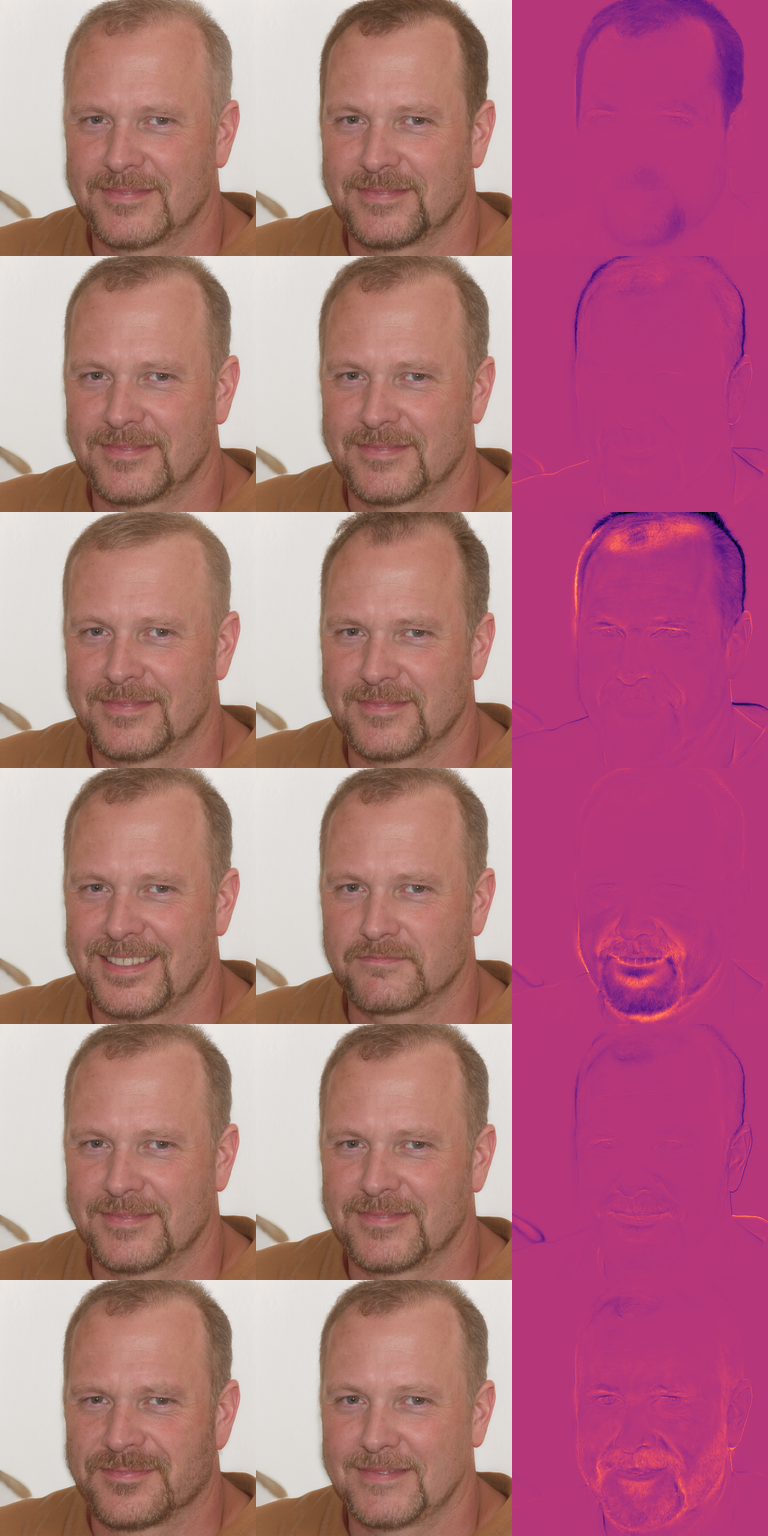

In [26]:
display(Image.fromarray(np.vstack(factor_array_hard)))

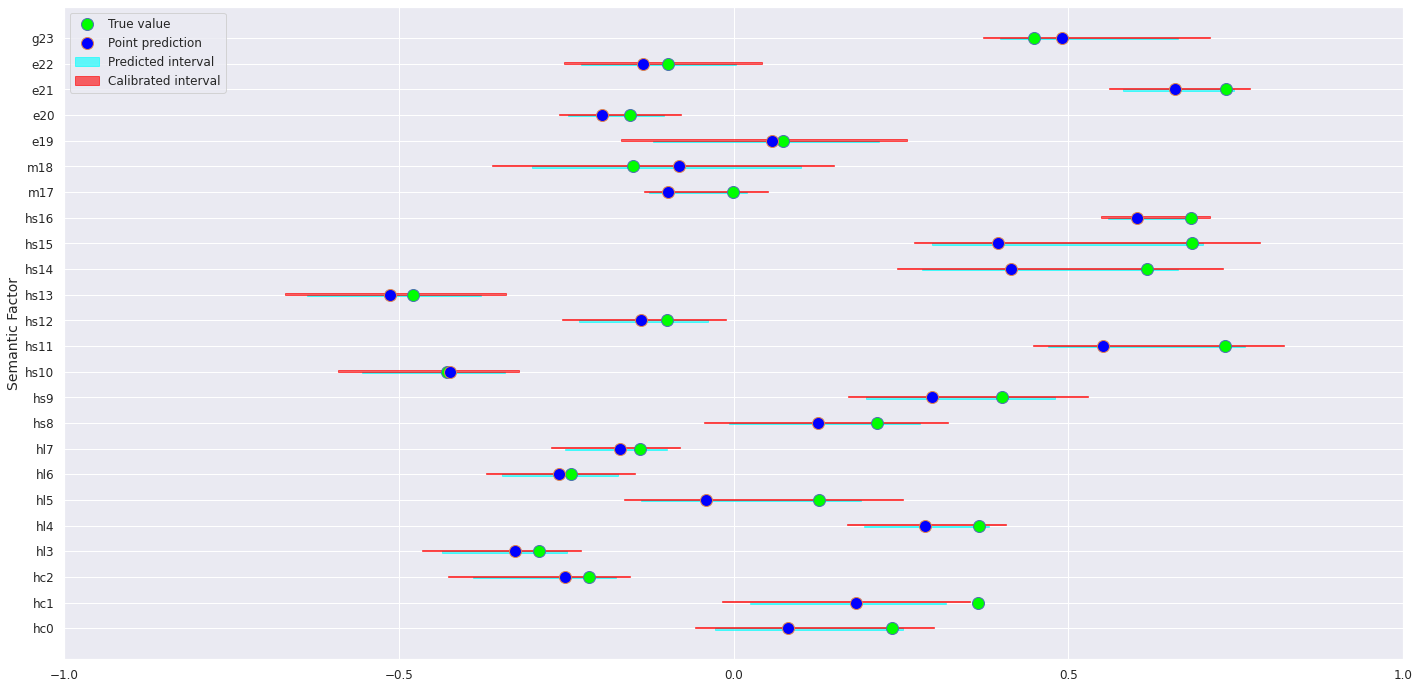

In [27]:
difficulty_level = 'easy'
out4 = results_obj.visualize_style_space_intervals(difficulty_level=difficulty_level, image_index=image_index, plot_type='calibration_interval')
plt.savefig(f'factor_intervals_{difficulty_level}_calibration_interval.png', dpi=300, bbox_inches='tight')